In [1]:
from PIL import Image
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from MainFunctions import discretizeData, prepareRealData

# Loading all LABSYSTEM PRO Images for semi-autmatic processing
Preprocessed ECG images contain 12 signals each, separated into temp and img. This method concatenates them into one single img

In [5]:
n_images = len(os.listdir("ECGcutouts/automaticimgs/templates"))
imgs = []

for i in range(1,n_images+1):
    tmp = cv2.imread(f"ECGcutouts/automaticimgs/templates/trainimg{i}.png", 0)
    img = cv2.imread(f"ECGcutouts/automaticimgs/imgs/trainimg{i}.png",  0)
    # if two images should not be exactly same size
    if tmp.shape != img.shape:
        maxsize =  max(tmp.shape[1], img.shape[1]), max(tmp.shape[0], img.shape[0])
        tmp = cv2.resize(tmp,maxsize)
        img = cv2.resize(img,maxsize)
        print(f"Unequal Shape Detected! {tmp.shape} and {img.shape}")
    comb = np.concatenate([tmp, img], axis=1)
    imgs.append(comb)  
   

# Resizing combined img into appropriate format and executing signal seperation

Each combined img is saved into a seperate folder, with all folders using the prefix 100 indicating semi-automated processing

In [9]:
j = 0
# iterating over each combined img
for img in imgs:
    os.mkdir(f"ECGcutouts/realimgs/100_{j}") if not os.path.exists(f"ECGcutouts/realimgs/100_{j}") else None
    img = cv2.resize(img,(400,1200))
    window = 50
    signals = []
    row = 0
    i = 0
# detecting singals per combined img, max 12 signals available
    while row < img.shape[0]:
        if img[row].sum() != 0:
            # 25 pixels up
            start = row - math.floor(window * 0.5) if row > window  else 0
            # 75 pixels down
            end = row + math.floor(window * 1.5)  if row + window  < img.shape[0] else img.shape[0]
            testimg = img[start : end]
            signals.append(testimg)
            row = row + window 
        else :
            row = row + 1
            
# Cutting detected signal in half vertically distinguishing template and match img, max 24 signals should be possible
    for signal in signals:
        if signal.sum()!= 0:
            signal1 = signal[:,0:200]
            signal2 = signal[:,200:]
            Image.fromarray(signal1).save(f"ECGcutouts/realimgs/100_{j}/img{i}.png")
            i += 1
            Image.fromarray(signal2).save(f"ECGcutouts/realimgs/100_{j}/img{i}.png")
            i += 1
    j += 1



# Processing labels 
At this point all labels have been added manually to the folders created above. Moreover manually processed images are stored in separate folders under the parent directory realimgs.
Now, all ECG images are used, manually processed ones and semi-autmatic images obtained from above,
we want to provide am overview of the labels distribution 

In [98]:
df = prepareRealData("ECGcutouts/realimgs")
df = discretizeData(df, start=-99, stop=109, step=10, seed=42)
df = df.groupby(["bins", "bin_lbls"]).count()

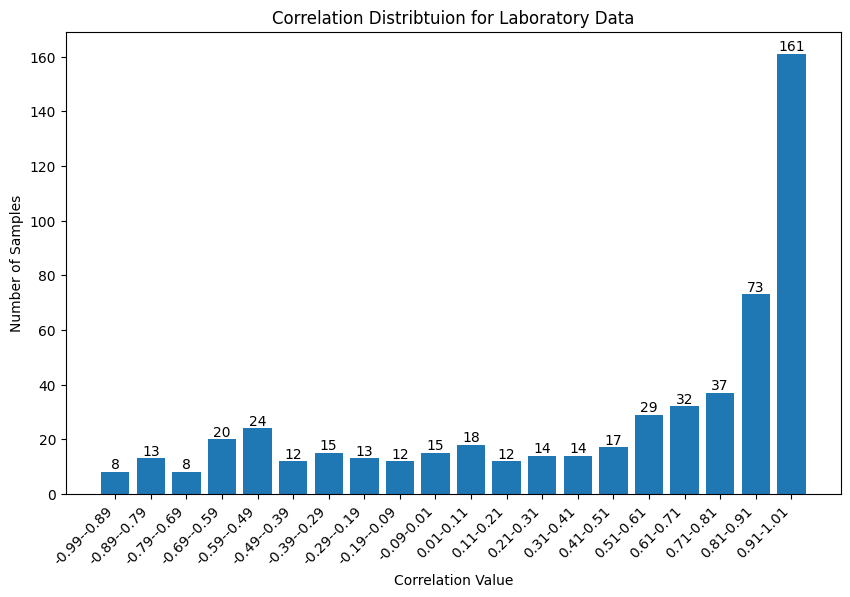

In [94]:
plt.figure(figsize=(10,6))
g = plt.bar(x=df.index.get_level_values(1), height=df["label"], label=df["label"].to_numpy())
plt.xticks(rotation=45, ha='right')
plt.title("Correlation Distribtuion for Laboratory Data")
plt.ylabel("Number of Samples")
plt.xlabel("Correlation Value")
g = plt.bar_label(g)